In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

rf of preselected series codes (topics)

In [17]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')

In [18]:
# extracting the most relevant topics
s = pd.read_csv(r'/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/WDISeries.csv')
s = s[~((s['Series Code'].str.startswith("AG", na=False)) | (s['Series Code'].str.startswith("BG", na=False)) | (s['Series Code'].str.startswith("BM", na=False)) | 
          (s['Series Code'].str.startswith("BN", na=False)) | (s['Series Code'].str.startswith("BX", na=False)) | (s['Series Code'].str.startswith("DC", na=False)) | 
          (s['Series Code'].str.startswith("EG", na=False)) | (s['Series Code'].str.startswith("EN", na=False)) | (s['Series Code'].str.startswith("ER", na=False)) | 
          (s['Series Code'].str.startswith("GB", na=False)) | (s['Series Code'].str.startswith("IC", na=False)) | (s['Series Code'].str.startswith("IP", na=False)) | 
          (s['Series Code'].str.startswith("IS", na=False)) | (s['Series Code'].str.startswith("LP", na=False)) | (s['Series Code'].str.startswith("ST", na=False)) | 
          (s['Series Code'].str.startswith("TM", na=False)) | (s['Series Code'].str.startswith("TX", na=False)))]

codes_to_keep = s.loc[:,'Series Code'].unique()
codes_to_keep

array(['CC.EST', 'CC.NO.SRC', 'CC.PER.RNK', ..., 'VC.IHR.PSRC.FE.P5',
       'VC.IHR.PSRC.MA.P5', 'VC.IHR.PSRC.P5'], shape=(1100,), dtype=object)

In [19]:
# rf on subset of topics 

# remove other ODA data
exclude_keywords = r"(?i)\baid\b|development assistance|ODA|primary income|official flows"
non_oda_data = og[~og['Indicator Name'].str.contains(exclude_keywords, na=False)]

target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

df_filtered = pd.concat([non_oda_data, target_oda_data])

df_filtered = df_filtered[df_filtered['Indicator Code'].isin(codes_to_keep)]

df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [20]:
df_long = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

In [21]:
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]
df_pivot = df_pivot.sort_values(["Country Code", "Year"])

threshold = 0.5*len(df_pivot)
df_cleaned = df_pivot.dropna(axis = 1, thresh = threshold)
df = df_cleaned.copy()

In [22]:
# creating 1 year lagged target variable
df['target_lag1'] = df.groupby('Country Code')['Net official development assistance received (constant 2021 US$)'].shift(1)
df = df.dropna(subset=['target_lag1'])
df['Year'] = df['Year'].astype(int)

df.to_csv('pivot_lagged_clean.csv', index=False)

In [23]:

# separate features from target 
y = np.arcsinh(df['target_lag1']) # transform because of skew
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'target_lag1', 'Country Name', 'Country Code', 'Year'])

# Handle missing values 
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split
cutoff = 2017
train_mask = df['Year'] <= cutoff
test_mask = df['Year'] > cutoff

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_86663/2136799601.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_86663/2136799601.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_86663/2136799601.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Train RMSE: 2.5857
Test RMSE: 4.0423
Train R²: 0.7570
Test R²: 0.5309


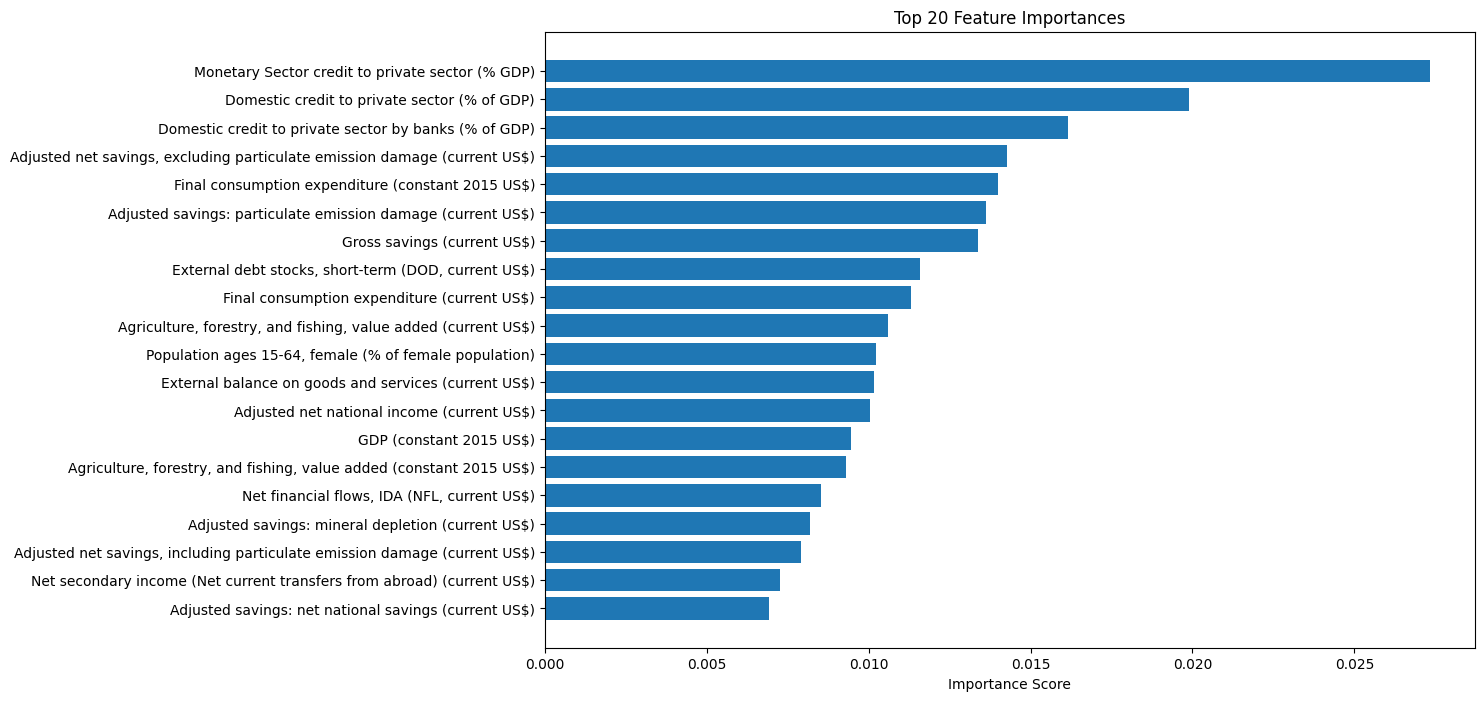

In [24]:

## Random Forest Implementation

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  
)

rf.fit(X_train_scaled, y_train)

train_pred = rf.predict(X_train_scaled)
test_pred = rf.predict(X_test_scaled)

# Evaluate
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, test_pred):.4f}")

## Feature Importance Visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

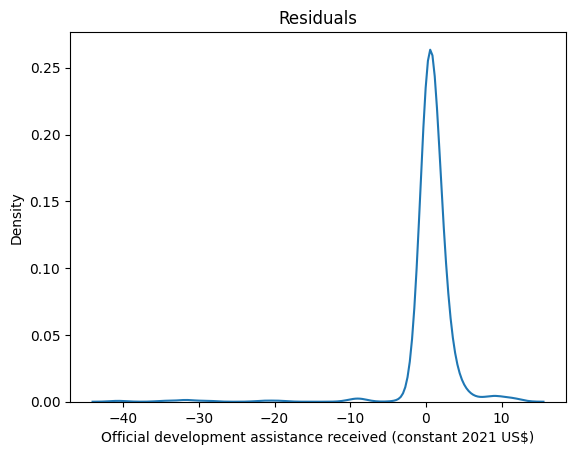

In [25]:
## Residuals
e = y_test - test_pred
sns.kdeplot(e).set(title='Residuals') 
plt.xlabel('Official development assistance received (constant 2021 US$)')
plt.show()

RF on specific preselected features

In [26]:
df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [27]:
# Filter rows to preselected Series Codes (specific variables)
s = pd.read_csv(r'/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/WDISeries.csv')
s = s[(s['Series Code'] == "CC.PER.RNK") | (s['Series Code'] == "DT.DOD.DIMF.CD") | (s['Series Code'] == "DT.DOD.PVLX.GN.ZS") | 
      (s['Series Code'] == "FD.AST.PRVT.GD.ZS") | (s['Series Code'] == "FP.CPI.TOTL") | (s['Series Code'] == "GE.PER.RNK") | 
      (s['Series Code'] == "HD.HCI.OVRL") | (s['Series Code'] == "MS.MIL.XPND.ZS") | (s['Series Code'] == "NY.GDP.PCAP.KD") | 
      (s['Series Code'] == "NY.GNP.PCAP.KD") | (s['Series Code'] == "PV.PER.RNK") | (s['Series Code'] == "RL.PER.RNK") | 
      (s['Series Code'] == "SE.ADT.LITR.ZS") | (s['Series Code'] == "SE.ADT.1524.LT.ZS") | (s['Series Code'] == "SE.SEC.NENR.FE") | 
      (s['Series Code'] == "SE.XPD.SECO.PC.ZS") | (s['Series Code'] == "SG.VAW.1549.ZS") | (s['Series Code'] == "SH.DTH.IMRT") | 
      (s['Series Code'] == "SH.DYN.AIDS.ZS") | (s['Series Code'] == "SH.H2O.SMDW.ZS") | (s['Series Code'] == "SH.STA.BASS.ZS") | 
      (s['Series Code'] == "SI.POV.GINI") | (s['Series Code'] == "SI.POV.SOPO") | (s['Series Code'] == "SN.ITK.MSFI.ZS") | 
      (s['Series Code'] == "SP.DYN.IMRT.IN") | (s['Series Code'] == "SP.POP.GROW") | (s['Series Code'] == "VC.IHR.PSRC.FE.P5") | 
      (s['Series Code'] == "VC.IDP.NWCV") | (s['Series Code'] == "VA.PER.RNK")]
codes_to_keep = s.loc[:,'Series Code'].unique()
codes_to_keep

array(['CC.PER.RNK', 'DT.DOD.DIMF.CD', 'DT.DOD.PVLX.GN.ZS',
       'FD.AST.PRVT.GD.ZS', 'FP.CPI.TOTL', 'GE.PER.RNK', 'HD.HCI.OVRL',
       'MS.MIL.XPND.ZS', 'NY.GDP.PCAP.KD', 'NY.GNP.PCAP.KD', 'PV.PER.RNK',
       'RL.PER.RNK', 'SE.ADT.1524.LT.ZS', 'SE.ADT.LITR.ZS',
       'SE.SEC.NENR.FE', 'SE.XPD.SECO.PC.ZS', 'SG.VAW.1549.ZS',
       'SH.DTH.IMRT', 'SH.DYN.AIDS.ZS', 'SH.H2O.SMDW.ZS',
       'SH.STA.BASS.ZS', 'SI.POV.GINI', 'SI.POV.SOPO', 'SN.ITK.MSFI.ZS',
       'SP.DYN.IMRT.IN', 'SP.POP.GROW', 'VA.PER.RNK', 'VC.IDP.NWCV',
       'VC.IHR.PSRC.FE.P5'], dtype=object)

In [28]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')

In [29]:
target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

features = og[og['Indicator Code'].isin(codes_to_keep)]

df_filtered = pd.concat([features, target_oda_data])

df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [30]:
df_long = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

In [31]:
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]
df_pivot = df_pivot.sort_values(["Country Code", "Year"])

threshold = 0.5*len(df_pivot)
df_cleaned = df_pivot.dropna(axis = 1, thresh = threshold)
df = df_cleaned.copy()

In [32]:
# create 1 year lagged target variable
df['target_lag1'] = df.groupby('Country Code')['Net official development assistance received (constant 2021 US$)'].shift(1)
df = df.dropna(subset=['target_lag1'])
df['Year'] = df['Year'].astype(int)

In [33]:

# separate features from target 
y = np.arcsinh(df['target_lag1']) # transform because of skew
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'target_lag1', 'Country Name', 'Country Code', 'Year'])

# Handle missing values 
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split
cutoff = 2017
train_mask = df['Year'] <= cutoff
test_mask = df['Year'] > cutoff

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train RMSE: 2.7325
Test RMSE: 4.2224
Train R²: 0.7286
Test R²: 0.4882


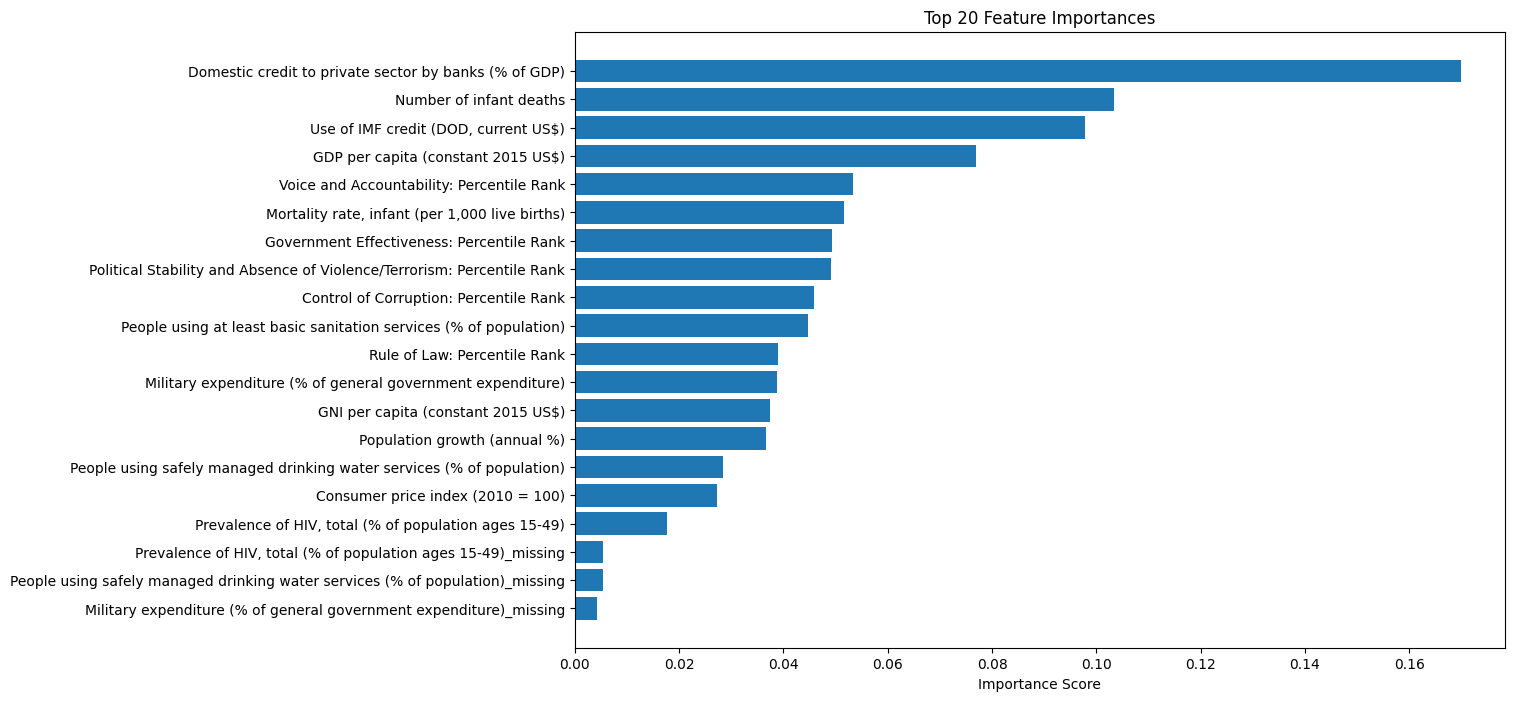

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Random Forest Implementation

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  
)

rf.fit(X_train_scaled, y_train)
train_pred = rf.predict(X_train_scaled)
test_pred = rf.predict(X_test_scaled)

# Evaluate
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, test_pred):.4f}")

## Feature Importance Visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

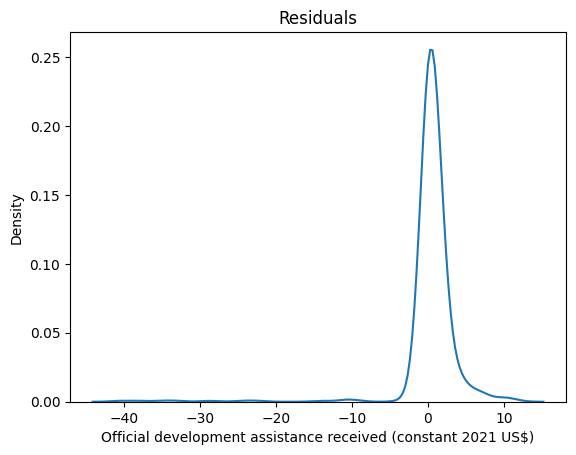

In [ ]:
import seaborn as sns
## Residuals 
e = y_test - test_pred
sns.kdeplot(e).set(title='Residuals') 
plt.xlabel('Official development assistance received (constant 2021 US$)')
plt.show()